# Data Ingestion and BERT Preparation

# A. Environment Setup

In [1]:
!pip install bert-for-tf2
!pip install sentencepiece

In [0]:
%tensorflow_version 2.x

In [3]:
import pandas as pd
import numpy as np
import nltk
import sklearn

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import io
import os
import math
import zipfile
import time

from tqdm import tqdm
from pprint import pprint

# Suppress new window for plots
%matplotlib inline 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score

In [0]:
import tensorflow as tf
import tensorflow_hub as hub
import bert

In [0]:
from tensorflow.keras.models import  Model
from tqdm import tqdm
from collections import namedtuple

In [7]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
print('sklearn: %s' % sklearn.__version__)

TensorFlow Version: 2.2.0-rc2
Hub version:  0.8.0
sklearn: 0.22.2.post1


In [9]:
from google.colab import files, drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import gc
gc.collect() # Force garbage collector to release unreferenced memory
!ls

drive  sample_data


# B. Functions

## B.1 Global Variables

In [0]:
path_to_data = "/content/drive/My Drive/Colab Notebooks/W266 Final Project/data/"
csv_filename_in = "dataset.csv"
#csv_filename_in = "baseline2_dataset.csv"
csv_filename_out = "baseline2_dataset_bal.csv"

## B.2 Data Pre-Processing Functions

In [0]:
def text_company(df, text_field):  
  print("Starting text_company()...")
  start = time.time()
  df[text_field] = df[text_field].str.lower()
  end = time.time()
  print("Finished making it lowercase:", (end - start))
  
  start = time.time()  
  df[text_field] = df[text_field].str.replace(r"greenshades support", "clientswsupport")
  end = time.time()
  print("Finished removing 'greenshades support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades software support", "clientswsupport")
  end = time.time()  
  print("Finished removing 'greenshades software support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades partner support", "partnerswsupport")
  end = time.time()
  print("Finished removing 'greenshades partner support':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades ticket", "ticket")
  end = time.time()
  print("Finished removing 'greenshades ticket':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades online", "")
  end = time.time()
  print("Finished removing 'greenshades online':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.greenshades.com", "")
  end = time.time()
  print("Finished removing 'www.greenshades.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshadesonline.com", "")
  end = time.time()
  print("Finished removing 'greenshadesonline.com':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"greenshades", "")
  end = time.time()
  print("Finished removing 'greenshades':", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"green shades", "")
  end = time.time()
  print("Finished removing 'green shades':", (end - start))
  print("Finished text_company().")
  return df

In [0]:
def text_normalize(df, text_field):
  print("Starting text_normalize()...")
  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"<[^>]+>", "") # Delete any string between "<" and ">"
  end = time.time()
  print("Finished deleting strings between <>")
  print (end - start)

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"www.*?.com", "") 
  end = time.time()
  print("Finished deleting websites:", (end - start))

  start = time.time()
  df[text_field] = df[text_field].str.replace(r"http\S+", "")
  end = time.time()
  print("Finished deleting http\S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"\d+", "") # Remove any strings of numbers
  end = time.time()
  print("Finished deleting numbers:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"@\S+", "")
  end = time.time()
  print("Finished removing S+:", (end - start))

  start = time.time()    
  df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9\.\=]", " ")
  end = time.time()
  print("Finished removing non-alpha numerics excluding punctuation (.=):", (end - start)) # old .,;:!

  print("Finished text_normalize().")
  return df

In [0]:
def tokens_to_string(input_list):
  return ' '.join(input_list)

## B.3 Plotting Functions

In [0]:
def plot_cm(y_true, y_pred, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    fig, ax = plt.subplots(figsize=figsize)
    colormap = sns.diverging_palette(220, 20, sep=20, as_cmap=True) #plt.cm.coolwarm #coolwarm_r reverse
    sns.heatmap(cm, 
                cmap=colormap, 
                annot=annot, 
                annot_kws={"size": 12}, 
                fmt='',
                linewidths=1, 
                square=True, 
                ax=ax)
    ax.set_title('Confusion Matrix\n', fontsize=16, weight='bold');
    ax.set_xlabel('\n\nPredicted Label', fontsize=12);
    ax.set_ylabel('Actual Label\n\n', fontsize=12);

In [0]:
def plt_barchart(df, title):
  sns.set_style("white")

  df2 = df.groupby('PriorityID').agg({'PriorityID':['count']}).reset_index()
  df2.columns = ['PriorityID', 'count']
  df2['pct'] = df2['count']*100/(sum(df2['count']))

  x = df2['PriorityID']
  y = df2['pct']

  palette = ['red','orange', 'green', 'yellow']

  fig, ax = plt.subplots(figsize = (8,4))
  fig = sns.barplot(y, x, estimator = sum, ci = None, orient='h', palette=palette)

  for i, v in enumerate(y):
    ax.text(v+1, i+.05, str(round(v,3))+'%', color='black', fontweight='bold')

  ax.set(xlim=(0,100))
  plt.title(title + '\nTicket Priority as Percentage of Total', size=16, weight='bold')
  plt.ylabel('Ticket Priority')
  plt.xlabel('% Total');

In [0]:
def prt_counts(df, title):
  df2 = df.groupby('PriorityID').agg({'PriorityID':['count']}).reset_index()
  df2.columns = ['PriorityID', 'count']
  print(title)
  print("-"*20)
  print(df2)
  print("-"*20)
  total = df2["count"].sum()
  print("Total count = ", total)
  print()

In [0]:
def plot_history(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

## B.4 Utility Functions

In [0]:
priority_dict = {'Low': 0,'Normal':1,'High':2,'Critical': 3}
def map_priority(priority, priority_dict = {}):
  val = priority_dict[priority]
  return val

In [0]:
def tokenize_note(note):
  '''Simple wrapper for tokenizing a note to its ids.'''
  return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(note))

In [0]:
def truncate_tokenized_note(tokenized_note,length):
  '''Truncates a tokenized note to the specified number of tokens(length).'''
  if len(tokenized_note) > length:
    tokenized_note = tokenized_note[:length]
  return tokenized_note

In [0]:
def create_tokenized_field(df, text_field, new_token_field):
  print("Starting create_tokenized_field()...")
  printAfter = 500000
  print("Total lines in loop")
  print(len(df[text_field]))
  start = time.time()

  new_tokens = [[]]*len(df[text_field])

  token_time = 0
  filter_time = 0
  assign_to_token_time = 0  

  for i in range(0, len(df[text_field])):
    start_inner = time.time()
    tokens = word_tokenize(df[text_field][i])
    end_inner = time.time()
    token_time += (end_inner - start_inner)

    start_inner = time.time()    
    filtered_tokens = [w for w in tokens]
    end_inner = time.time()
    filter_time += (end_inner - start_inner)

    start_inner = time.time()        
    new_tokens[i] = filtered_tokens
    end_inner = time.time()
    assign_to_token_time += (end_inner - start_inner)

    if i % printAfter == 0 and i != 0:      
      print("Finished lines:", i)
      print("Token Time:", token_time)
      print("Filter Time:", filter_time)
      print("Assign To Token Time:", assign_to_token_time)      
      token_time = 0
      filter_time = 0
      assign_to_token_time = 0    
      
  df[new_token_field] = new_tokens
  end = time.time()
  print("Create tokenized field time:", (end - start))
  start = time.time()

  print("Finished create_tokenized_field().")
  return df

In [0]:
def releaseDF(df):
    '''
    Release dataframe from memory
    '''
    list_df = [df]
    del list_df
    return

## B.5 BERT Data Preparation Functions

In [0]:
def create_single_input(sentence, MAX_LEN):
  stokens = tokenizer.tokenize(sentence)
  stokens = stokens[:MAX_LEN]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids, masks, segments

In [0]:
def create_input_array(sentences):
  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences,position=0, leave=True):
    ids, masks, segments = create_single_input(sentence, MAX_SEQ_LEN-2)
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

In [0]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))

def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

# C. Import Pre-Processed Dataset

## C.1 Import Raw Dataset

In [28]:
%time dataset = pd.read_csv(path_to_data + csv_filename_in, dtype = {'Notes': str})

CPU times: user 105 ms, sys: 24.9 ms, total: 130 ms
Wall time: 586 ms


In [29]:
print(dataset.shape)

print(dataset.isnull().values.any())
print()
dataset.isnull().any()

(24199, 8)
True



Unnamed: 0       False
PriorityID       False
label            False
text              True
label_pr_low     False
label_pr_norm    False
label_pr_high    False
label_pr_crit    False
dtype: bool

In [30]:
print(dataset.isnull().T.any().T.sum()) # Number of rows with NaNs
print()
dataset[pd.isnull(dataset).any(axis=1)]

1



,Unnamed: 0,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
3786,3786,Normal,1,NaN,0,1,0,0


In [0]:
dataset = dataset.dropna(how="any")
dataset.reset_index(inplace=True, drop=True)

In [32]:
print(dataset.shape)
print(dataset.isnull().values.any())

(24198, 8)
False


In [33]:
dataset.head(5)

,Unnamed: 0,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit
0,0,Normal,1,created,0,1,0,0
1,1,Normal,1,efp auto ticket action error while handli...,0,1,0,0
2,2,Normal,1,this seems to be stuck on submitting,0,1,0,0
3,3,Normal,1,submitted,0,1,0,0
4,4,Normal,1,closing,0,1,0,0


In [34]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24198 entries, 0 to 24197
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     24198 non-null  int64 
 1   PriorityID     24198 non-null  object
 2   label          24198 non-null  int64 
 3   text           24198 non-null  object
 4   label_pr_low   24198 non-null  int64 
 5   label_pr_norm  24198 non-null  int64 
 6   label_pr_high  24198 non-null  int64 
 7   label_pr_crit  24198 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 1.5+ MB


## C.2 Train/Test Split

In [0]:
dataset.reset_index
dataset = dataset.rename(columns={'Unnamed: 0': 'OrigIndex'})

In [36]:
train, test = train_test_split(dataset,
                               test_size=0.2, 
                               shuffle=True,
                               random_state=273)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print("train shape: ", train.shape)
print("test shape:  ", test.shape)

train shape:  (19358, 8)
test shape:   (4840, 8)


In [0]:
train_OrigIndex_list = list(train.OrigIndex)
len(train_OrigIndex_list)

dataset['record_type'] = dataset['OrigIndex'].apply(lambda x: "train" if x in train_OrigIndex_list else "test")

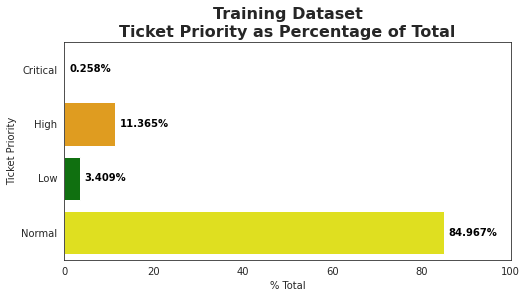

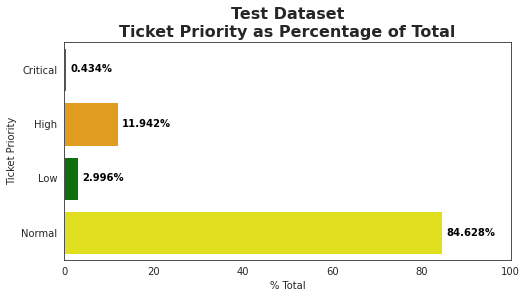

In [38]:
plt_barchart(train, "Training Dataset")
plt_barchart(test, "Test Dataset")

# D. Modeling Using Different Data Balancing Methods

## D.1 Compare Alternate ML Algorithms

In [0]:
tfidf = TfidfVectorizer(sublinear_tf=True, 
                        min_df=5, 
                        norm='l2', 
                        encoding='latin-1', 
                        ngram_range=(1, 3))

In [0]:
features = tfidf.fit_transform(dataset.text).toarray()
labels = dataset.label.values
print(features.shape)

(24198, 69994)


In [0]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

In [0]:
#models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
#models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))

In [0]:
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [0]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


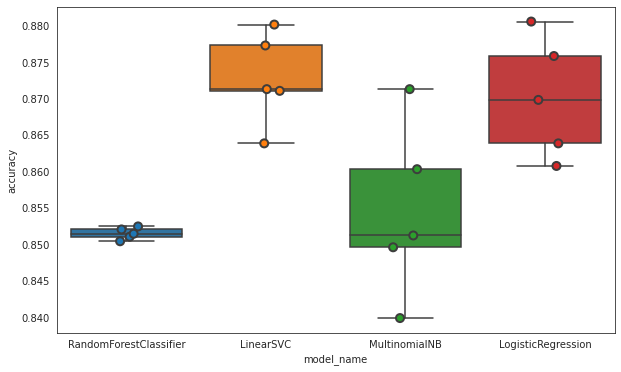

In [0]:
import seaborn as sns

plt.figure(figsize=(10,6))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.872717
LogisticRegression        0.870155
MultinomialNB             0.854451
RandomForestClassifier    0.851475
Name: accuracy, dtype: float64

In [0]:
# Release dataframe from memory
releaseDF(cv_df)
del(models)

## D.2 Baseline Model (LSVC, No Data Balancing)

In [0]:
train, test = train_test_split(dataset,
                               test_size=0.2, 
                               shuffle=True,
                               random_state=273)

train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

print("train shape: ", train.shape)
print("test shape:  ", test.shape)

train shape:  (19358, 9)
test shape:   (4840, 9)


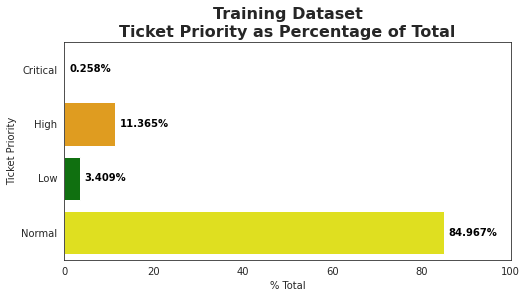

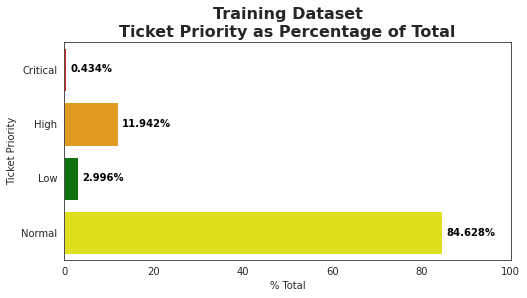

In [0]:
plt_barchart(train, "Training Dataset")
plt_barchart(test, "Training Dataset")

In [0]:
prt_counts(train, "Training Dataset")
print()
prt_counts(test, "Test Dataset")

Training Dataset
--------------------
  PriorityID  count
0   Critical     50
1       High   2200
2        Low    660
3     Normal  16448
--------------------
Total count =  19358


Test Dataset
--------------------
  PriorityID  count
0   Critical     21
1       High    578
2        Low    145
3     Normal   4096
--------------------
Total count =  4840



In [0]:
x_train, x_test, y_train, y_test, idx_train, idx_test = train_test_split(features,  
                                                                         labels,
                                                                         dataset.index,
                                                                         test_size=0.2, 
                                                                         shuffle=True,
                                                                         random_state=273)
print("train shape: ", x_train.shape)
print("test shape:  ", x_test.shape)

train shape:  (19358, 69994)
test shape:   (4840, 69994)


In [0]:
clf_lsvc = LinearSVC()
clf_lsvc.fit(x_train, y_train)
y_pred = clf_lsvc.predict(x_test)

              precision    recall  f1-score   support

     Low (0)     0.8235    0.2897    0.4286       145
  Normal (1)     0.9015    0.9766    0.9375      4096
    High (2)     0.7411    0.4308    0.5449       578
Critical (3)     0.9375    0.7143    0.8108        21

    accuracy                         0.8897      4840
   macro avg     0.8509    0.6028    0.6804      4840
weighted avg     0.8802    0.8897    0.8748      4840



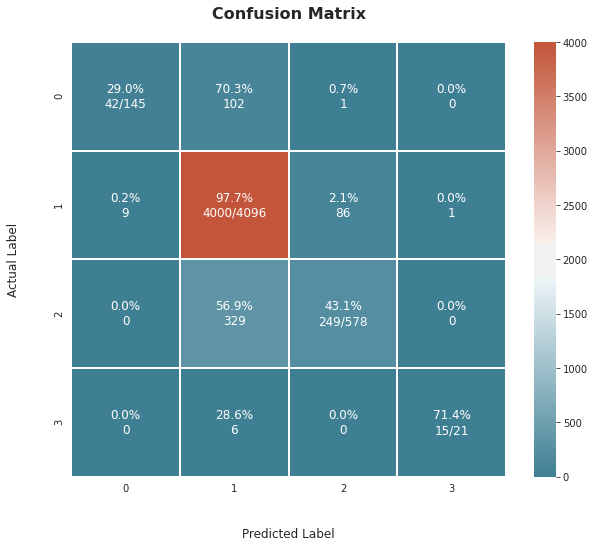

In [0]:
print(metrics.classification_report(y_test, 
                                    y_pred, 
                                    target_names=["Low (0)","Normal (1)","High (2)","Critical (3)"],
                                    digits=4))
plot_cm(y_test, y_pred)

## Method 1: Random Sampling to Equalize Normal and High Priority Tickets (LSVC)

In [0]:
train = dataset[dataset.record_type=="train"]
test = dataset[dataset.record_type=="test"]

In [0]:
prt_counts(train, "Training Dataset")
print()
prt_counts(test, "Test Dataset")

Training Dataset
--------------------
  PriorityID  count
0   Critical     50
1       High   2200
2        Low    660
3     Normal  16448
--------------------
Total count =  19358


Test Dataset
--------------------
  PriorityID  count
0   Critical     21
1       High    578
2        Low    145
3     Normal   4096
--------------------
Total count =  4840



In [0]:
df_low = train[train.PriorityID == 'Low']
df_norm = train[train.PriorityID == 'Normal']
df_high = train[train.PriorityID == 'High']
df_crit = train[train.PriorityID == 'Critical']

# Resample training dataset based on "Low" PriorityID count
n = len(df_low)

df_norm = df_norm.sample(n)
df_high = df_high.sample(n)

train = df_low.append(df_norm)
train = train.append(df_high)
train = train.append(df_crit)

train = train.sample(frac=1, random_state = 273).reset_index(drop=True)

In [0]:
train.head()

,OrigIndex,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit,record_type
0,19129,Low,0,not getting a but am now getting a because ...,1,0,0,0,train
1,17313,High,2,created,0,0,1,0,train
2,7670,Low,0,good morning minnie i am contacting you ...,1,0,0,0,train
3,1033,High,2,this should be live now please verify and red...,0,0,1,0,train
4,1108,Critical,3,created efp auto ticket action webs...,0,0,0,1,train


Training Dataset
--------------------
  PriorityID  count
0   Critical     50
1       High    660
2        Low    660
3     Normal    660
--------------------
Total count =  2030



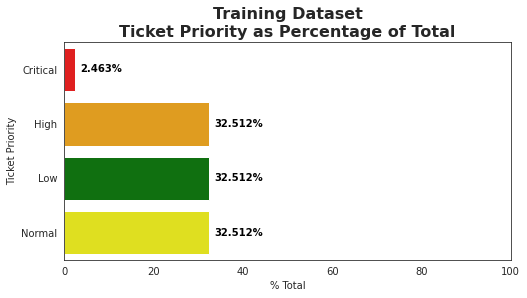

In [0]:
prt_counts(train, "Training Dataset")
plt_barchart(train, "Training Dataset")

Test Dataset
--------------------
  PriorityID  count
0   Critical     21
1       High    578
2        Low    145
3     Normal   4096
--------------------
Total count =  4840



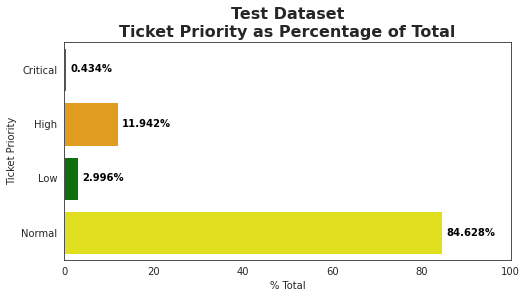

In [0]:
prt_counts(test, "Test Dataset")
plt_barchart(test, "Test Dataset")

In [0]:
df_new = train.append(test)
df_new = df_new.sort_values(by='record_type', ascending=False)
df_new.reset_index(inplace=True, drop=True)
df_new.shape

(6870, 9)

In [0]:
df_new.head()

,OrigIndex,PriorityID,label,text,label_pr_low,label_pr_norm,label_pr_high,label_pr_crit,record_type
0,19129,Low,0,not getting a but am now getting a because ...,1,0,0,0,train
1,6685,Normal,1,client emailed from clientswsupp...,0,1,0,0,train
2,8204,Normal,1,created,0,1,0,0,train
3,22165,High,2,can we have the client cancel their sync and t...,0,0,1,0,train
4,3193,Normal,1,client has a version of the tfc that contains ...,0,1,0,0,train


In [0]:
n = len(train)
m = len(df_new)

In [0]:
# Check separation
df_train = df_new[:n]
df_test = df_new[n:m]
df_train.shape
df_train.record_type.unique()
df_test.record_type.unique()

array(['test'], dtype=object)

In [0]:
features = tfidf.fit_transform(df_new.text).toarray()
labels = df_new.label.values
print(features.shape)

(6870, 21793)


In [0]:
# Create Training Data
x_train = features[:n]
y_train = labels[:n]

In [0]:
# Create Test Data
x_test = features[n:m]
y_test = labels[n:m]

In [0]:
clf_lsvc.fit(x_train, y_train)
y_pred = clf_lsvc.predict(x_test)

              precision    recall  f1-score   support

     Low (0)     0.1856    0.6207    0.2857       145
  Normal (1)     0.9344    0.7339    0.8221      4096
    High (2)     0.3289    0.6384    0.4341       578
Critical (3)     0.9375    0.7143    0.8108        21

    accuracy                         0.7190      4840
   macro avg     0.5966    0.6768    0.5882      4840
weighted avg     0.8397    0.7190    0.7596      4840



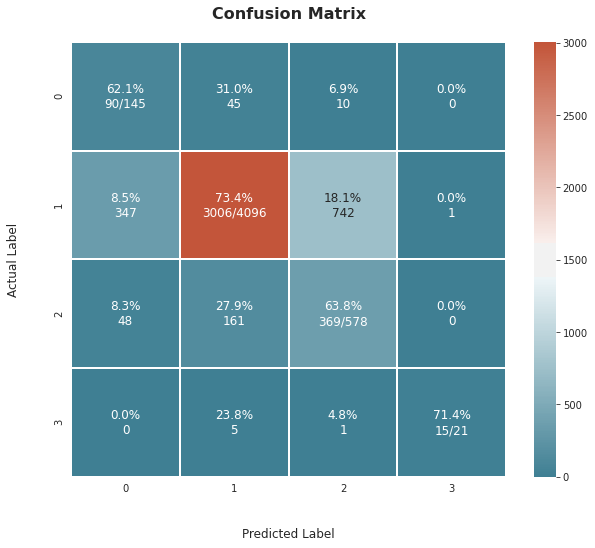

In [0]:
print(metrics.classification_report(y_test, 
                                    y_pred, 
                                    target_names=["Low (0)","Normal (1)","High (2)","Critical (3)"],
                                    digits=4))

plot_cm(y_test, y_pred)

## D.3 Save Balanced Dataset

In [0]:
# Save dataframe to shared Google drive project data folder
dataset.to_csv(path_to_data + filename_out)

# E. Baseline Modeling

## E.0 Define Global Model-Related Variables

In [0]:
bert_path = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
MAX_SEQ_LEN = 128

## E.1 Define BERT Layer

In [0]:
bert_layer = hub.KerasLayer(bert_path, 
                            trainable=False, # Set to false for finetuning
                            name="bert_layer")

input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                       dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                   dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), 
                                    dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [0]:
FullTokenizer = bert.bert_tokenization.FullTokenizer

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = FullTokenizer(vocab_file, do_lower_case)

## E.2 Define Custom Layers

In [0]:
layer1 = tf.keras.layers.GlobalAveragePooling1D(name="layer1")(sequence_output)

In [0]:
out = tf.keras.layers.Dense(4, # We need the output predictions for each of the four categories
                            activation="sigmoid", # Because we want the probability of each class
                            name="dense_output")(layer1)

## E.3 Preview Model Architecture

In [0]:
model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], 
                              outputs=out)

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

## E.4 Train Model

In [0]:
train_sentences = train.text
list_classes = ['label_pr_low', 'label_pr_norm', 'label_pr_high', 'label_pr_crit']
train_y = train[list_classes].values

In [47]:
sentence = train_sentences[15913]
MAX_LEN = MAX_SEQ_LEN

stokens = tokenizer.tokenize(sentence)
stokens = stokens[:MAX_LEN]
stokens = ["[CLS]"] + stokens + ["[SEP]"]
ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
masks = get_masks(stokens, MAX_SEQ_LEN)
segments = get_segments(stokens, MAX_SEQ_LEN)
name=segments
print()
print(type(name[0]))
print(len(name))
print(name)


<class 'int'>
130
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
def create_single_input(sentence, MAX_LEN):
  stokens = tokenizer.tokenize(sentence)
  stokens = stokens[:MAX_LEN]
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)

  return ids, masks, segments

In [0]:
def create_input_array(sentences):
  input_ids, input_masks, input_segments = [], [], []

  for sentence in tqdm(sentences, position=0, leave=True):
    ids, masks, segments = create_single_input(sentence, MAX_SEQ_LEN-2)
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)

  return [np.asarray(input_ids, dtype=np.int32),
          np.asarray(input_masks, dtype=np.int32), 
          np.asarray(input_segments, dtype=np.int32)]

In [50]:
train_x = create_input_array(train_sentences)

100%|██████████| 19358/19358 [00:19<00:00, 992.61it/s]


In [54]:
train_x

[array([[  101,  2123,  1056, ...,     0,     0,     0],
        [  101, 10373,  2013, ...,     0,     0,     0],
        [  101, 25212,  2003, ...,     0,     0,     0],
        ...,
        [  101,  1041, 22540, ...,  1037,  7909,   102],
        [  101,  2013,  7846, ...,     0,     0,     0],
        [  101,  7396,  2170, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]

In [51]:
num_epochs = 1
history = model.fit(train_x, train_y,
                    epochs=num_epochs,
                    batch_size=32,
                    validation_split=0.2,
                    shuffle=True)

 11/484 [..............................] - ETA: 11:41 - loss: 0.4365 - accuracy: 0.8040

KeyboardInterrupt: ignored

In [0]:
plot_history(history, "accuracy")
plot_history(history, "loss")

In [0]:
releaseDF(history)

## E.5 Evaluate Model

In [0]:
test_sentences = test.text
test_x = create_input_array(test_sentences)

test_pred = model.predict(test_x)

In [0]:
y_pred = np.argmax(test_pred, axis=1)
y_true = test.label.values

In [0]:
plot_cm(y_true, y_pred)

In [0]:
print(metrics.classification_report(y_true, 
                                    y_pred, 
                                    target_names=["Low (0)","Normal (1)","High (2)","Critical (3)"],
                                    digits=4))